In [1]:
import pandas as pd
import numpy as np
# from dataprep.eda import create_report
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split



In [17]:
df_train = pd.read_csv('train_users_2.csv')
# df_test = pd.read_csv('test_users.csv')
# df_country = pd.read_csv('countries.csv')
df_age = pd.read_csv('age_gender_bkts.csv')
df_sessions = pd.read_csv('sessions.csv')

In [ ]:
df_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_bucket               420 non-null    object 
 1   country_destination      420 non-null    object 
 2   gender                   420 non-null    object 
 3   population_in_thousands  420 non-null    float64
 4   year                     420 non-null    float64
dtypes: float64(2), object(3)
memory usage: 16.5+ KB


## Age bucket distribution
https://www.kaggle.com/code/asmaamohy/airbnb-eda had a good few charts, this is one of the best ones I found

<ipython-input-6-44f42654d071>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_age,x="country_destination",y="population_in_thousands",hue='age_bucket',ci=None,ax=ax)


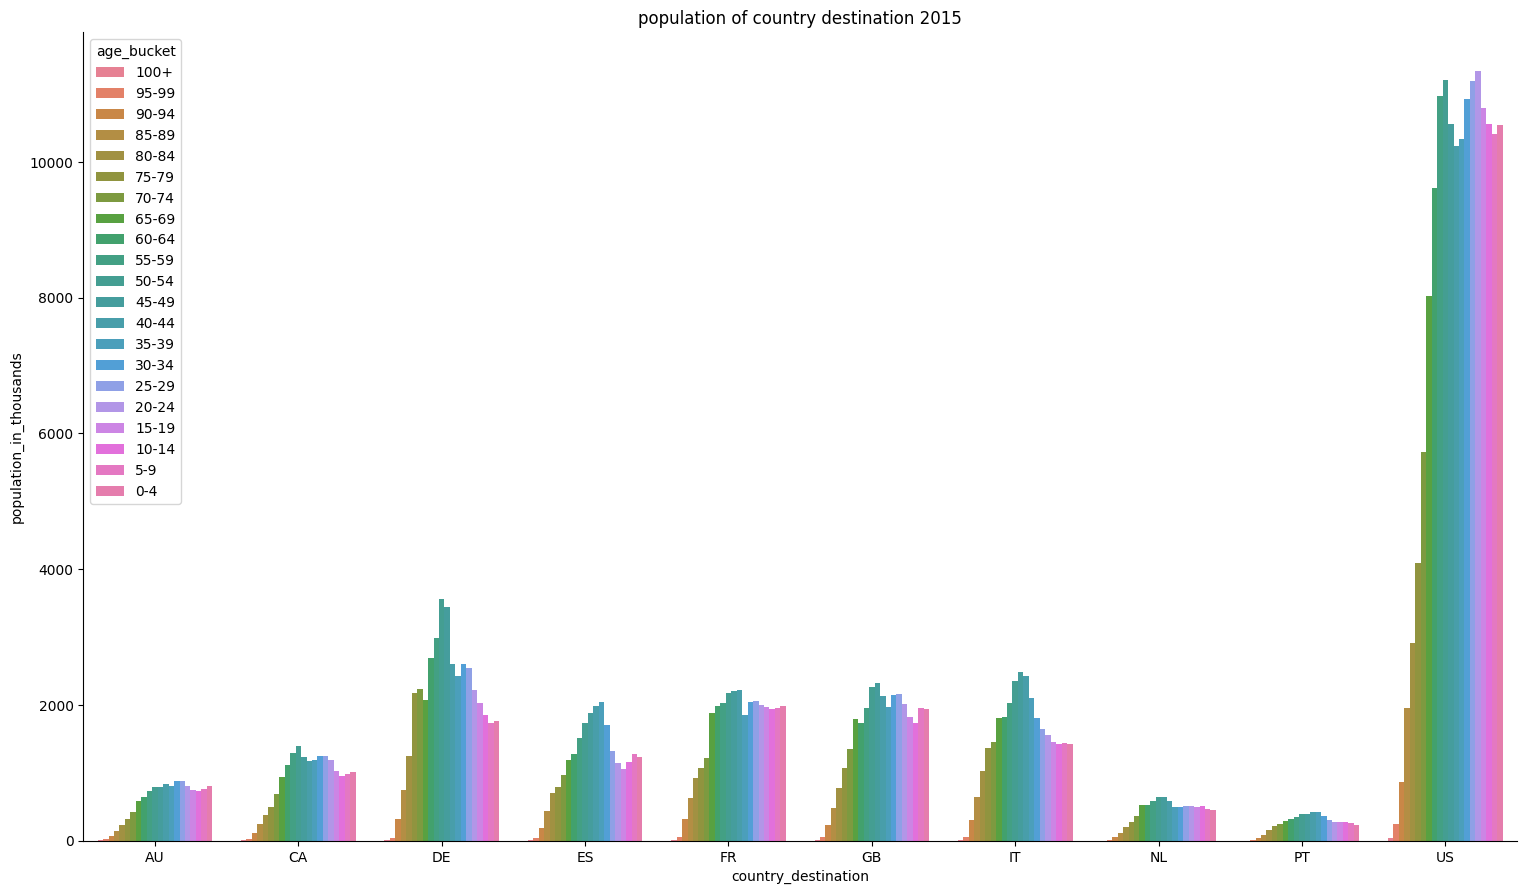

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
sns.barplot(data=df_age,x="country_destination",y="population_in_thousands",hue='age_bucket',ci=None,ax=ax)
plt.title('population of country destination 2015')
sns.despine()

## I liked this from Pawans Analysis

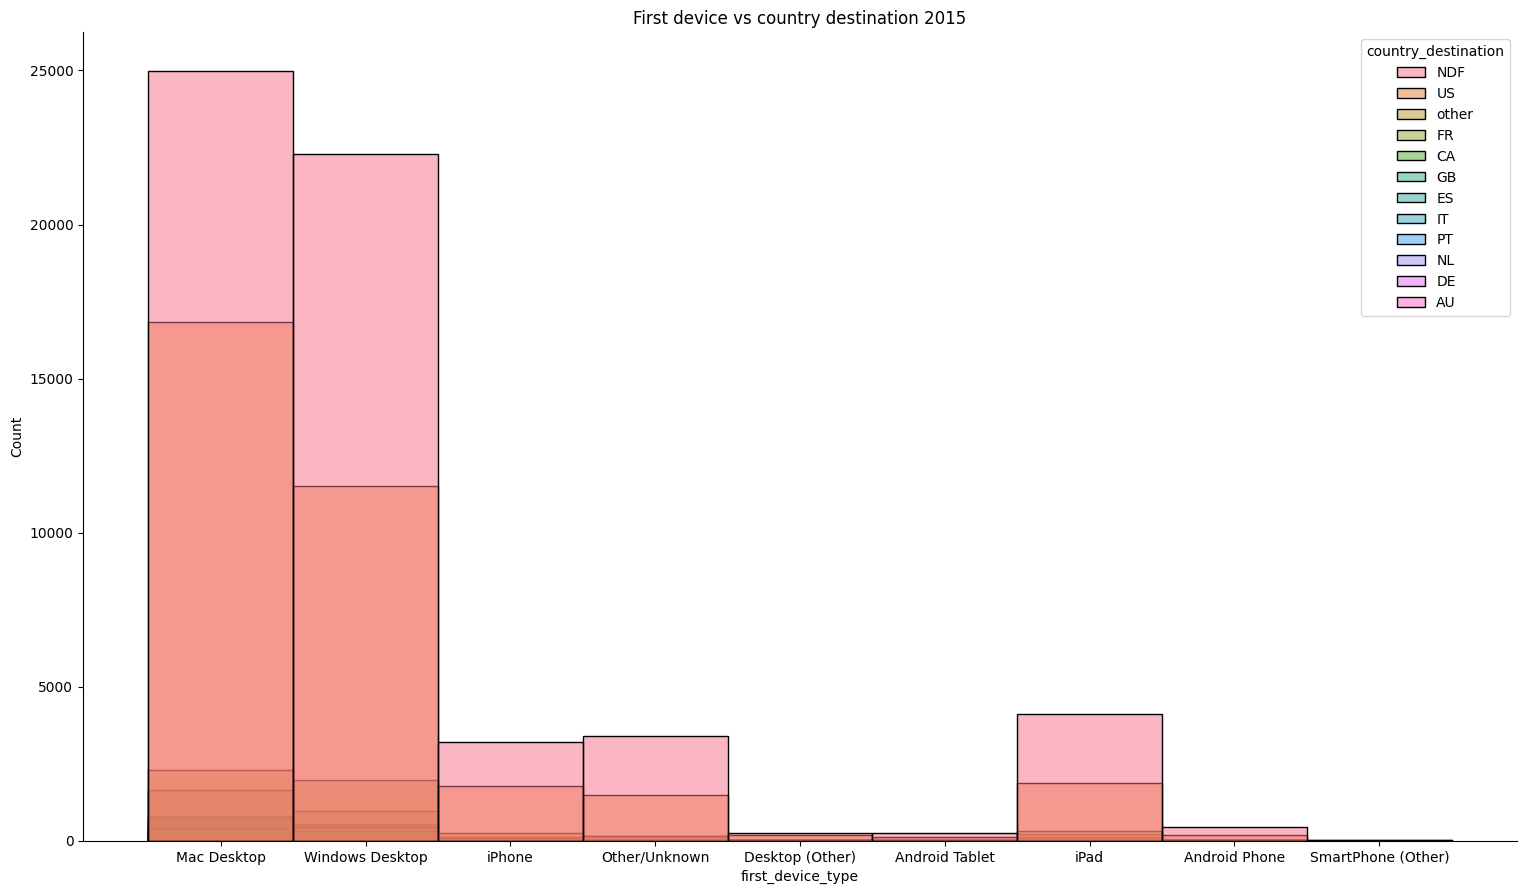

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
sns.histplot(data=df_train,x="first_device_type",hue='country_destination',ax=ax)
plt.title('First device vs country destination 2015')
sns.despine()

In [ ]:
# prompt: list column names in df_train

print(df_train.columns.to_list())


['id', 'date_account_created', 'timestamp_first_active', 'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'country_destination']


In [3]:
non_numeric_cols = df_train.select_dtypes(include=["object"]).columns.tolist()
print(non_numeric_cols)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in non_numeric_cols:
    df_train[col] = le.fit_transform(df_train[col])

['id', 'date_account_created', 'date_first_booking', 'gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'country_destination']


In [ ]:
missing_value_counts = df_train.isnull().sum()
print(missing_value_counts)
print(df_train.shape[0])

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking             0
gender                         0
age                        40418
signup_method                  0
signup_flow                    1
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked        0
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
dtype: int64
107749


In [4]:

# Splitting features and target
X = df_train.drop('country_destination', axis=1)
y = df_train['country_destination']

# Dropping age from X because it has a lot of missing values
# X = X.drop('age', axis=1)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Applying SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled_test, y_resampled_test = smote.fit_resample(X_test, y_test)

# Checking the class distribution
print(f'Original dataset class distribution:\n{y_train.value_counts()}')
print(f'Resampled dataset class distribution:\n{pd.Series(y_resampled).value_counts()}')

combined_data = pd.concat([X_resampled, y_resampled], axis=1)
combined_test = pd.concat([X_resampled_test, y_resampled_test], axis=1)
print(combined_data.head())

Original dataset class distribution:
country_destination
7     87337
10    43591
11     7081
4      3518
6      1969
5      1576
3      1563
1      1008
2       727
8       537
0       368
9       140
Name: count, dtype: int64
Resampled dataset class distribution:
country_destination
7     87337
10    87337
11    87337
4     87337
0     87337
3     87337
8     87337
5     87337
6     87337
1     87337
2     87337
9     87337
Name: count, dtype: int64
       id  date_account_created  timestamp_first_active  date_first_booking  \
0  111091                  1531          20140320194657                1976   
1   91507                  1630          20140627200146                1976   
2  212627                   615          20110916063203                 600   
3   48623                  1545          20140403003645                1530   
4  157425                  1572          20140430204559                1559   

   gender  signup_method  signup_flow  language  affiliate_channel  \


## Data After Sampling Histograms


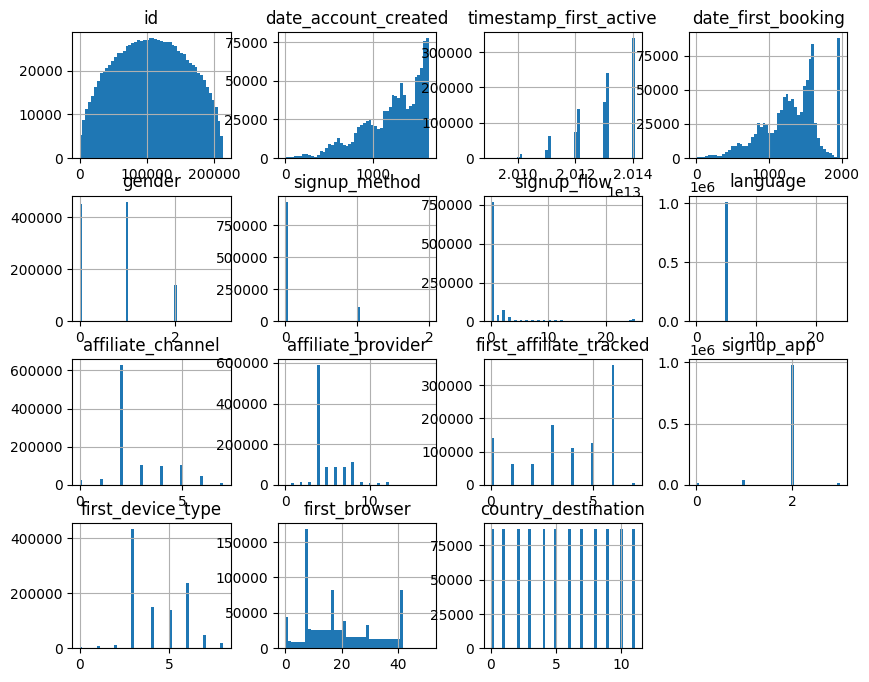

In [ ]:
combined_data.hist(figsize=(10,8), bins=50)
plt.show()

## Data without Sampling Histograms

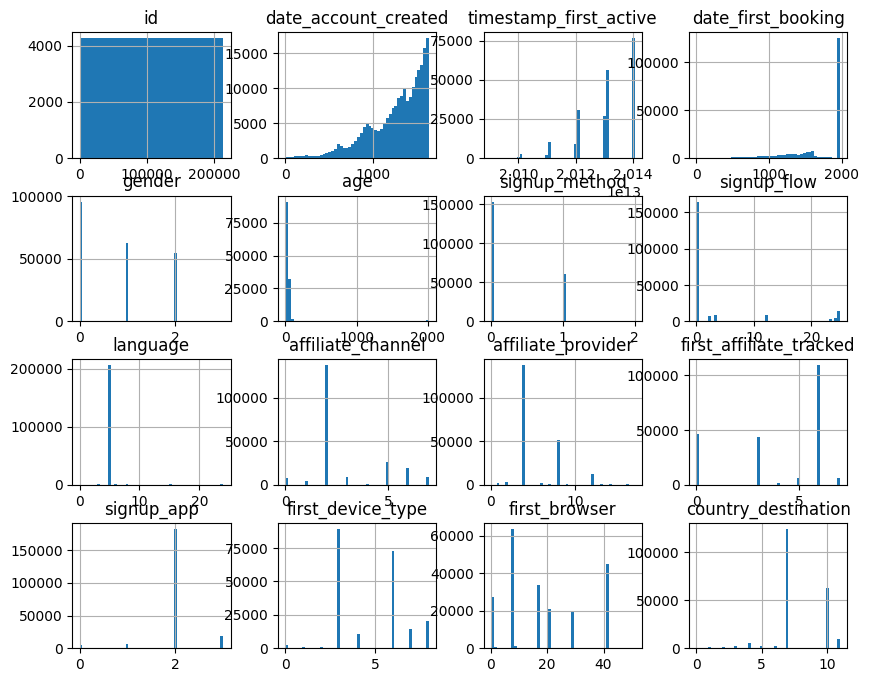

In [ ]:
df_train.hist(figsize=(10,8), bins=50)
plt.show()

## Data After Sampling Heatmap

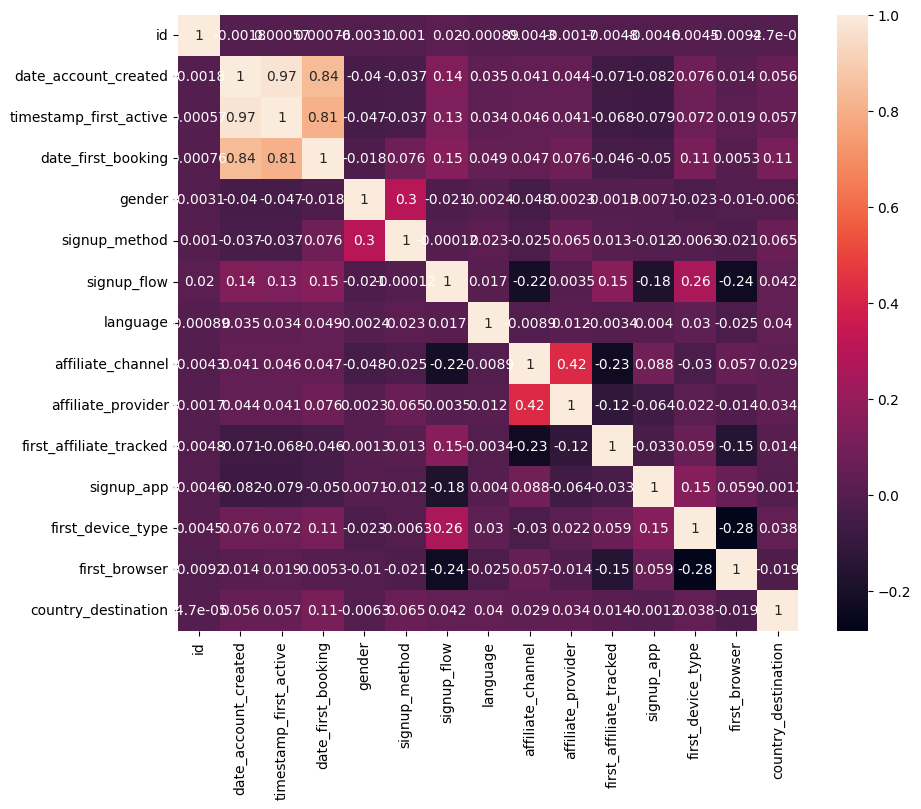

In [ ]:
correlation_matrix = combined_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

## Data Before Sampling Heatmap

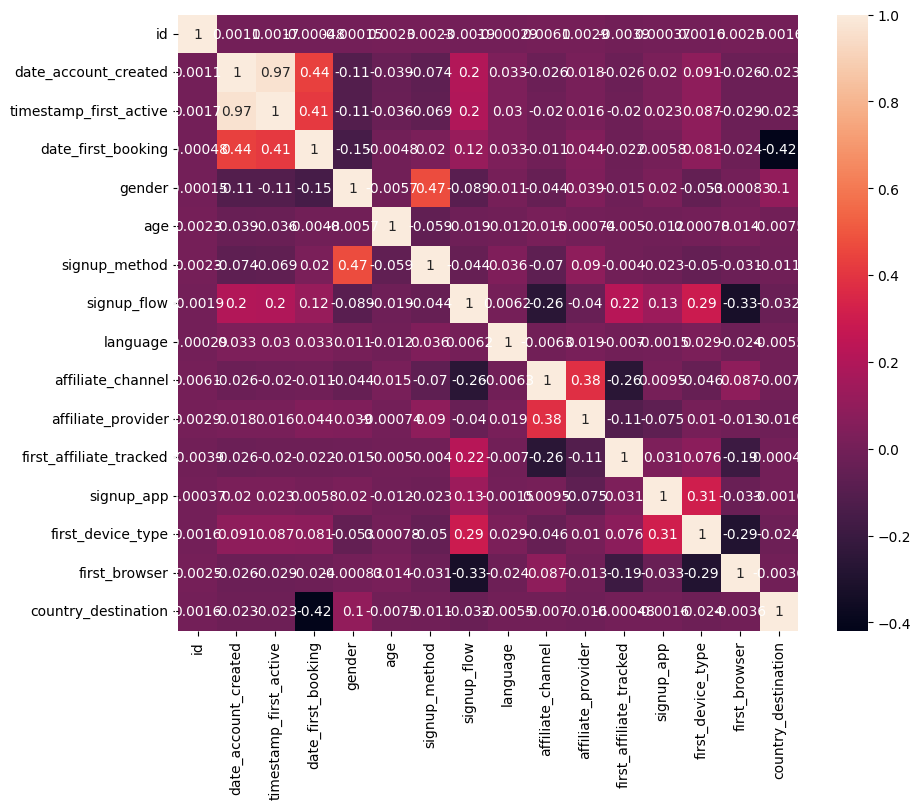

In [ ]:
correlation_matrix = df_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [22]:
# prompt: can you help me count and identify rows that have "unknown" for gender, "NDF" for country_destination, and NaN value for age. Only if all 3 of those conditions are true do I want this row to be flagged

flagged_rows = df_train.loc[(df_train['gender'] == '-unknown-') & (df_train['country_destination'] == 'NDF') & (df_train['age'].isna())]
flagged_rows_gender = df_train.loc[(df_train['gender'] == '-unknown-')]
flagged_rows_destination = df_train.loc[(df_train['country_destination'] == 'NDF')]
flagged_rows_age = df_train.loc[(df_train['age'].isna())]

# Count the number of flagged rows
num_flagged_rows_gender = len(flagged_rows_gender)
num_flagged_rows_destination = len(flagged_rows_destination)
num_flagged_rows_age = len(flagged_rows_age)
num_flagged_rows = len(flagged_rows)
# Print the number of flagged rows
print(f"Number of flagged rows gender: {num_flagged_rows_gender}")
print(f"Number of flagged rows destination: {num_flagged_rows_destination}")
print(f"Number of flagged rows age: {num_flagged_rows_age}")

print(f"Number of flagged rows: {num_flagged_rows}")
# Print the flagged rows
# print(flagged_rows)
# print(df_train.dtypes)
flagged_ids = flagged_rows['id'].tolist()
unique_ids_in_sessions = df_sessions[df_sessions['user_id'].isin(flagged_ids)]['user_id'].nunique()
print(f"Number of flagged unique ids in sessions: {unique_ids_in_sessions}")
print(f"Number of total unique ids in sessions: {df_sessions['user_id'].nunique()}")
# ids_in_sessions = df_sessions['user_id'].isin(flagged_ids).sum()
# print(f"Number of flagged ids found in df_sessions: {ids_in_sessions}")



Number of flagged rows gender: 95688
Number of flagged rows destination: 124543
Number of flagged rows age: 87990
Number of flagged rows: 61865
Number of flagged unique ids in sessions: 2652
Number of total unique ids in sessions: 7794


## Ensemble Model



In [8]:
# Handle missing values
combined_data.fillna(combined_data.mean(), inplace=True)


# Handle outliers
for col in combined_data.columns:
  if combined_data[col].dtype in ['float64', 'int64']:
    IQR = combined_data[col].quantile(0.75) - combined_data[col].quantile(0.25)
    lower_bound = combined_data[col].quantile(0.25) - 1.5 * IQR
    upper_bound = combined_data[col].quantile(0.75) + 1.5 * IQR
    # Instead of clipping, replace outliers with bounds
    combined_data[col] = np.where((combined_data[col] < lower_bound) | (combined_data[col] > upper_bound),
                           np.where(combined_data[col] < lower_bound, lower_bound, upper_bound),
                           combined_data[col])

# Extract feature matrix X and target variable y
X = combined_data.drop('country_destination', axis=1)
y = combined_data['country_destination']

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

selector = SelectKBest(f_regression, k=10)
X_new = selector.fit_transform(X, y)

# Print the features with the highest predictive power
for i in range(len(selector.scores_)):
  print(f"{X.columns[i]}: {selector.scores_[i]}")

id: 0.002338576950341805
date_account_created: 3256.3753591366194
timestamp_first_active: 3411.839210768563
date_first_booking: 13093.813644512862
gender: 42.909906938135705
signup_method: 0.0
signup_flow: 114.18909627299307
language: 0.0
affiliate_channel: 315.45681231952244
affiliate_provider: 763.3194452559256
first_affiliate_tracked: 215.27216770685894
signup_app: 0.0
first_device_type: 1497.6145599823776
first_browser: 367.440656624295


In [9]:
# Handle missing values
combined_test.fillna(combined_test.mean(), inplace=True)


# Handle outliers
for col in combined_test.columns:
  if combined_test[col].dtype in ['float64', 'int64']:
    IQR = combined_test[col].quantile(0.75) - combined_test[col].quantile(0.25)
    lower_bound = combined_test[col].quantile(0.25) - 1.5 * IQR
    upper_bound = combined_test[col].quantile(0.75) + 1.5 * IQR
    # Instead of clipping, replace outliers with bounds
    combined_test[col] = np.where((combined_test[col] < lower_bound) | (combined_test[col] > upper_bound),
                           np.where(combined_test[col] < lower_bound, lower_bound, upper_bound),
                           combined_test[col])

# Extract feature matrix X and target variable y
X_test = combined_test.drop('country_destination', axis=1)
y_test = combined_test['country_destination']



In [ ]:
# Handle missing values
df_train.fillna(df_train.mean(), inplace=True)


# Handle outliers
for col in df_train.columns:
  if df_train[col].dtype in ['float64', 'int64']:
    IQR = df_train[col].quantile(0.75) - df_train[col].quantile(0.25)
    lower_bound = df_train[col].quantile(0.25) - 1.5 * IQR
    upper_bound = df_train[col].quantile(0.75) + 1.5 * IQR
    # Instead of clipping, replace outliers with bounds
    df_train[col] = np.where((df_train[col] < lower_bound) | (df_train[col] > upper_bound),
                           np.where(df_train[col] < lower_bound, lower_bound, upper_bound),
                           df_train[col])

# Extract feature matrix X and target variable y
X = df_train.drop('country_destination', axis=1)
y = df_train['country_destination']

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

selector = SelectKBest(f_regression, k=10)
X_new = selector.fit_transform(X, y)

# Print the features with the highest predictive power
for i in range(len(selector.scores_)):
  print(f"{X.columns[i]}: {selector.scores_[i]}")

id: 0.5697202642583092
date_account_created: 133.10330599664837
timestamp_first_active: 138.8074150624817
date_first_booking: 54878.125872052835
gender: 2509.9469069507572
age: 2985.449364581549
signup_method: 33.91949096757057
signup_flow: 0.0
language: 0.0
affiliate_channel: 10.225290786859947
affiliate_provider: 66.91407695471167
first_affiliate_tracked: 0.005380043021954839
signup_app: 0.0
first_device_type: 149.2359615745767
first_browser: 1.7164730232184202


In [12]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor # Use Regressor instead of Classifier

# Define the base models
rfr = RandomForestRegressor(random_state=42)
abr = AdaBoostRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)

estimators = [('rfr', rfr), ('abr', abr), ('gbr', gbr)]
ensemble = VotingRegressor(estimators) # Use Regressor instead of Classifier

ensemble_train = ensemble.fit(X_new, y)

# Apply feature selection to X_test as well
X_test_new = selector.transform(X_test)  # Use the same selector object

ensemble_test = ensemble.fit(X_test_new, y_test)  # Fit on transformed data

print(f"Train score: {ensemble_train.score(X_new, y)}")
print(f"Test score: {ensemble_test.score(X_test_new, y_test)}") # Score using transformed data

Train score: -0.024689422702653285
Test score: 0.55864412297013
